In [1]:
from support.df_init import init

train = init()
test = init('pp_test.csv')

In [3]:
train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'countryOfOrigin', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 'countryOfOrigin_AF', 'countryO

In [25]:
feats = [
    'numRegions',
    'totalMedia',
    'totalCredits', 
    'totalNominations',
    'rating',
    'startYear',
    'canHaveEpisodes',
    'runtimeMinutes_notitletype',
    'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
    'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
    # 'is_Musical', 'is_Western',
    'is_Music', 
    # 'is_Film-Noir',
    'is_Adult',
    'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
    'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
    'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
    'countryOfOrigin_freq_enc',
    'countryOfOrigin_NA',
    'countryOfOrigin_AS',
    'countryOfOrigin_EU',
    'countryOfOrigin_OC',
    'countryOfOrigin_SA',
    'countryOfOrigin_UNK',
    'criticReviewsTotal', 'userReviewsTotal',
    # 'is_from_Oceania', 'is_from_North America',
    # 'is_from_South America', 'is_from_Asia', 'is_from_Africa',
    # 'is_from_Europe',
]

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform


# Prepare the data
X_train = train[feats]
y_train = train['titleType']

X_test = test[feats]
y_test = test['titleType']

# Scale the features


# Define the model
dt = DecisionTreeClassifier(random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1,50),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 30),
    'max_features': [None, 'sqrt', 'log2']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=500,
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate the model on the training set
y_train_pred = random_search.best_estimator_.predict(X_train)
print('Train Set Classification Report:')
print(classification_report(y_train, y_train_pred))

# Evaluate the model on the test set
y_pred = random_search.best_estimator_.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'criterion': 'entropy', 'max_depth': 34, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 18, 'splitter': 'best'}
Best Score: 0.8241775091370144
Train Set Classification Report:
              precision    recall  f1-score   support

       movie       0.90      0.94      0.92      5535
       short       0.93      0.96      0.95      2474
   tvEpisode       0.92      0.95      0.93      4698
tvMiniSeries       0.70      0.57      0.63       224
     tvMovie       0.67      0.49      0.57       868
    tvSeries       0.93      0.96      0.95      1375
     tvShort       0.55      0.15      0.24        40
   tvSpecial       0.51      0.27      0.35       166
       video       0.77      0.61      0.68       792

    accuracy                           0.89     16172
   macro avg       0.76      0.66      0.69     16172
weighted avg       0.89      0.89      0.89     16172

Test Set Classification Report:
              precision    recall  f1-score   supp

In [27]:
random_search.best_estimator_.feature_importances_

array([8.51418302e-02, 2.34844047e-02, 4.04502314e-02, 1.58585422e-02,
       1.81742757e-02, 6.50962275e-02, 2.17490860e-01, 1.61772144e-01,
       9.43688011e-03, 7.73312515e-05, 1.43460164e-03, 5.17421414e-04,
       6.00904555e-04, 4.68603272e-03, 1.44473346e-04, 3.34848842e-04,
       1.28467458e-03, 4.19989849e-03, 2.09182718e-02, 8.26337761e-04,
       1.03530475e-04, 6.59549571e-04, 2.90027017e-03, 2.35602093e-01,
       5.01984121e-04, 2.57379772e-03, 4.57676555e-04, 8.20341868e-04,
       6.21512104e-03, 3.42304368e-04, 0.00000000e+00, 9.08839878e-04,
       7.37522143e-03, 3.55864629e-02, 1.56309180e-03, 1.10136843e-02,
       2.11136299e-03, 8.93041073e-04, 1.82955524e-04, 2.36809886e-03,
       8.14715094e-03, 7.74322989e-03])

In [17]:
train.loc[train['countryOfOrigin_AF'] >= 1]

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,...,countryOfOrigin_AF,countryOfOrigin_AS,countryOfOrigin_EU,countryOfOrigin_OC,countryOfOrigin_SA,countryOfOrigin_UNK,fill_runtimeMinutes_Bruno,totalNominations,totalMedia,runtimeMinutes_notitletype
124,El Banat Ayza Eih,6,1980,1980.0,NaN,0.0,95,3,0,19,...,1,0,0,0,0,0,86.0,0.0,3,62.0
142,Hokm al kawi,8,1951,1951.0,103.0,0.0,21,2,0,10,...,1,0,0,0,0,0,103.0,0.0,2,103.0
295,Al Shaweesh Hassan,4,1988,1988.0,100.0,0.0,11,1,0,11,...,1,0,0,0,0,0,100.0,0.0,1,100.0
618,Captain Gallant of the Foreign Legion,8,1955,NaN,30.0,0.0,118,14,0,119,...,1,0,1,0,0,0,30.0,0.0,14,30.0
678,Hayat azeb,6,1963,1963.0,87.0,0.0,26,1,0,18,...,1,0,0,0,0,0,87.0,0.0,1,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15991,The Exchange: Six Faces of the Gambia,6,2009,2009.0,23.0,0.0,8,0,0,6,...,1,0,0,0,0,0,23.0,0.0,0,23.0
16032,Ace of Hearts: Bwana Y'umutima,9,2017,2017.0,120.0,0.0,13,2,0,18,...,1,0,0,0,0,0,120.0,0.0,2,120.0
16055,Soultan,7,1958,1958.0,115.0,0.0,53,1,0,16,...,1,0,0,0,0,0,115.0,0.0,1,115.0
16067,Afrobeats: From Nigeria to the World,7,2017,2017.0,52.0,0.0,14,1,0,9,...,4,0,1,0,0,0,52.0,0.0,1,52.0


In [12]:
train

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,...,countryOfOrigin_AF,countryOfOrigin_AS,countryOfOrigin_EU,countryOfOrigin_OC,countryOfOrigin_SA,countryOfOrigin_UNK,fill_runtimeMinutes_Bruno,totalNominations,totalMedia,runtimeMinutes_notitletype
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,1995.0,NaN,0.0,779,1,0,21,...,0,0,0,0,0,0,29.0,0.0,1,89.0
1,Idealnaya para,6,1992,1992.0,NaN,0.0,38,1,0,24,...,0,0,1,0,0,0,94.0,0.0,1,75.0
2,MasterChef Celebrity México,6,2021,NaN,NaN,0.0,15,22,0,56,...,0,0,0,0,0,0,30.0,0.0,22,60.0
3,Seutateueob,8,2020,2020.0,80.0,1.0,15718,347,2,47,...,0,1,0,0,0,0,80.0,2.0,349,80.0
4,Lightdance,9,1995,1995.0,34.0,0.0,14,1,0,0,...,0,0,0,0,0,0,34.0,0.0,1,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16167,Caprices,6,1942,1942.0,NaN,0.0,73,4,0,45,...,0,0,1,0,0,0,85.0,0.0,4,49.0
16168,Haar Jeet,5,1990,1990.0,NaN,0.0,15,2,0,22,...,0,1,0,0,0,0,86.0,0.0,2,78.0
16169,Kotigobba 3,6,2021,2021.0,140.0,0.0,2560,39,3,129,...,0,1,0,0,0,0,140.0,5.0,42,140.0
16170,Ator l'invincibile,4,1982,1982.0,NaN,0.0,3011,52,1,53,...,0,0,1,0,0,0,94.0,0.0,53,47.0


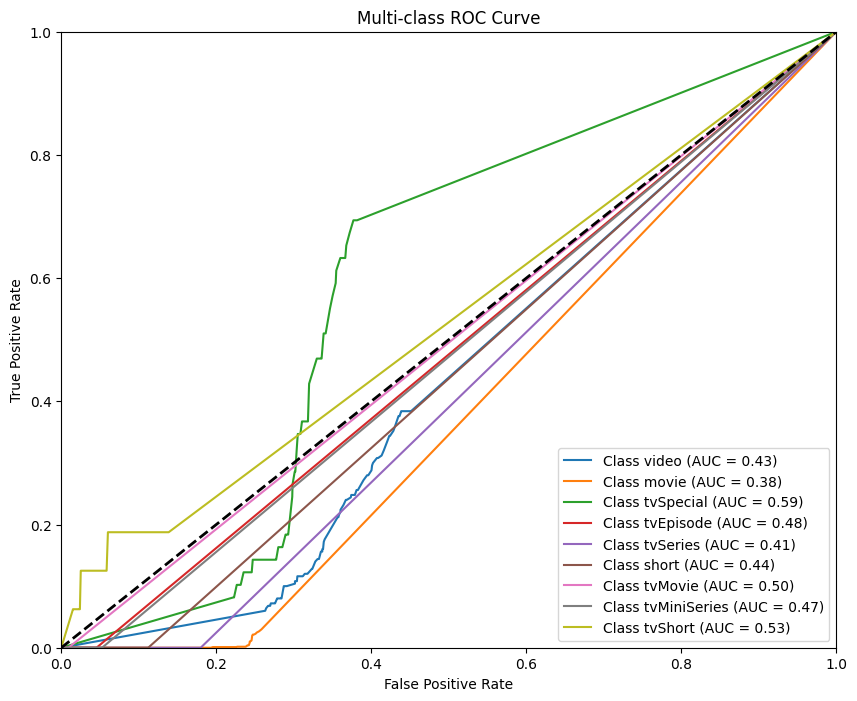

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

# Binarize the output labels for multi-class ROC
classes = y_test.unique()
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_proba = random_search.best_estimator_.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Add labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

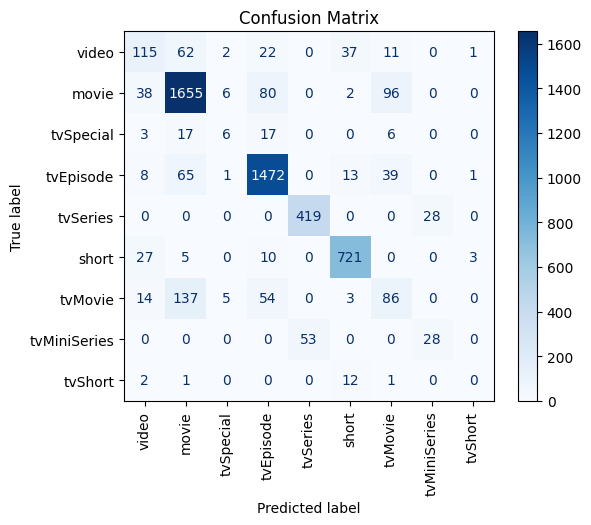

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()